# Image Caption Generator

### Import Section

In [1]:
from os import listdir
from pickle import dump
from keras.applications.vgg16 import VGG16
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.applications.vgg16 import preprocess_input
from keras.models import Model

Using TensorFlow backend.


### Preprocess image

In [2]:
# extrat Features
def extract_features(directory):
    
    model = VGG16()
    
    #remove last layer
    model.layers.pop()
    
    model = Model(inputs = model.inputs , outputs = model.layers[-1].output)
    
    print(model.summary())
    
    features = dict()
    
    for name in listdir(directory):
        
        # load and image
        filename = directory + '/' + name
        image = load_img(filename , target_size=(224 , 224))
        
        image = img_to_array(image)
        
        image = image.reshape((1 , image.shape[0] , image.shape[1] ,image.shape[2]))
        
        image = preprocess_input(image)
        
        feature = model.predict(image , verbose = 0)
        
        # get image id
        image_id = name.split(".")[0]
        
        # store features
        features[image_id] = feature
        
        print(name)
        
    return features

In [3]:
# directory = 'Dataset/flickr30k_dataset'
# features = extract_features(directory)
# print('extracted features :',len(features))
# dump(features , open('features.pkl' , 'wb'))

### Create Vocabulary from Images

In [4]:
import pandas as pd
import nltk
import re
from nltk.stem import WordNetLemmatizer

In [5]:
lemma = WordNetLemmatizer()

def load_decriptions(doc):
    mapping = dict()
    
    for i in range(len(doc)):
        image_id = doc['image_id'][i]
        image_desc = doc['desc'][i]
        
        if image_id not in mapping:
            mapping[image_id] = list()
        
        mapping[image_id].append(image_desc)
        
    return mapping

def clean_text(desc):
    
    # clean punctuation
    desc = re.sub(r'[^\w\s]' ,'', desc)
    
    # tokenize the words
    desc = desc.split()
    
    # convert to lower case
    desc = [token.lower() for token in desc]
    
    # lemmatization
    desc = [lemma.lemmatize(token) for token in desc]
    
    # remove numerical values
    desc = [token for token in desc if token.isalpha()]
    
    # join whole token
    desc = ' '.join(desc)
    
    return desc

In [6]:
# convert loaded descriptions into vocablury
def to_vocabluary(descriptions):
    all_desc = set()
    
    for key in descriptions.keys():
        [all_desc.update(d.split()) for d in descriptions[key]]
        
    return all_desc

def save_descriptions(descriptions , filename):
    lines = list()
    
    for key , desc_list in descriptions.items():
        for desc in desc_list:
            lines.append(key +' '+ desc)
            
    data = '\n'.join(lines)
    file = open(filename , 'w')
    file.write(data)
    file.close()            

In [7]:
descriptions = pd.read_csv('Dataset/results.csv' , sep='|')

In [8]:
descriptions.columns = ['image_id','no','desc']

In [9]:
descriptions.head()

,image_id,no,desc
0,1000092795.jpg,0,Two young guys with shaggy hair look at their...
1,1000092795.jpg,1,"Two young , White males are outside near many..."
2,1000092795.jpg,2,Two men in green shirts are standing in a yard .
3,1000092795.jpg,3,A man in a blue shirt standing in a garden .
4,1000092795.jpg,4,Two friends enjoy time spent together .


In [10]:
descriptions['desc'] = descriptions['desc'].apply(lambda x : clean_text(str(x)))

In [11]:
type(descriptions['desc'][0])

str

In [12]:
desc_map = load_decriptions(descriptions) # image name with Its captions

In [13]:
vocabulary = to_vocabluary(desc_map)

In [14]:
len(vocabulary)

16874

In [15]:
save_descriptions(desc_map , 'descriptions.txt')

### Train Set

In [16]:
from pickle import load

In [17]:
# loading the doc
def load_doc(filename):
    file = open(filename , 'r')
    text = file.read()
    file.close()
    return text

# this function is used for to get train image description from our dataset

def load_clean_descriptions(filename , dataset):
    doc = load_doc(filename)
    descriptions = dict()
    
    for line in doc.split('\n'):
        tokens = line.split()
        image_id , image_desc = tokens[0] , tokens[1:]
        
        if image_id in dataset:
            
            if image_id not in descriptions:
                descriptions[image_id] = list()
            
            # we add two tage at start and at end of the descitpion to identify to start and 
            # end of desc.
            desc = 'startseq '+ ' '.join(image_desc)+ ' endseq'
            descriptions[image_id].append(desc)
            
    return descriptions


# laod photo features
def load_photo_features(filename , dataset):
    all_features = load(open(filename,'rb'))
    features = {k+'.jpg' : all_features[k] for k in dataset}
    return features

In [18]:
train = set(descriptions['image_id'][:127125])
print('len of train image',len(train))

len of train image 25425


In [19]:
# traininset makinng and set startseq and endseq tag in descriptions
train_descriptions = load_clean_descriptions('descriptions.txt' , train) 

In [20]:
print('len of train descriptions' , len(train_descriptions))

len of train descriptions 25425


In [21]:
train = pd.DataFrame(train)

In [22]:
train2 = train[0].apply(lambda x : x.replace('.jpg' , '')) # remove jpg sign

In [23]:
# train features means feautures from training images
train_features = load_photo_features('features.pkl' , train2)
print('photos train :',len(train_features))

photos train : 25425


In [24]:
from tensorflow.keras.preprocessing.text import Tokenizer

In [25]:
# convert dictonary to lis descriptions

def to_lines(descriptions):
    all_desc = list()
    for key in descriptions.keys():
        [all_desc.append(d) for d in descriptions[key]]
        
    return all_desc

# fit tokenizer on descriptions
def create_tokenizer(descriptions):
    lines = to_lines(descriptions)
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(lines)
    return tokenizer

In [26]:
tokenizer = create_tokenizer(train_descriptions)
vocab_size = len(tokenizer.word_index) + 1
print('vocab size' , vocab_size)

vocab size 14936


In [27]:
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
import numpy as np

In [28]:
# calculate the length with most words
def max_length(descriptions):
    lines = to_lines(descriptions)
    return max([len(line.split())for line in lines])
    
# create sequences of images,input sequences and output sequences
def create_sequences(tokenizer , max_length , desc_list , photo):
    X1 , X2 , y = list() , list() , list()
    
    for desc in desc_list:
        # convert words to number value
        seq = tokenizer.texts_to_sequences([desc])[0]
        
        for i in range(1, len(seq)):
            
            in_seq , output_seq = seq[:i] , seq[i]
            in_seq = pad_sequences([in_seq] , maxlen = max_length)[0]
            output_seq = to_categorical([output_seq] , num_classes = vocab_size)[0]
            
            X1.append(photo)
            X2.append(in_seq)
            y.append(output_seq)
            
    return np.array(X1) , np.array(X2) , np.array(y)

### VGG16 + LSTM DeepModel

In [29]:
from keras.models import Model
from keras.layers import Input , Dense , LSTM , Embedding , Dropout
from keras.layers.merge import add
from keras.callbacks import EarlyStopping

In [30]:
def define_Model(vocab_size , max_length):
    
    # feature extractor model
    inputs1 = Input(shape=(4096 , ))
    fe1 = Dropout(0.5)(inputs1)
    fe2 = Dense(512 , activation='relu')(fe1)
    fe3 = Dense(256 , activation = 'relu')(fe2)
    
    # sequence model
    inputs2 = Input(shape=(max_length,))
    se1 = Embedding(vocab_size,512,mask_zero=True )(inputs2) # mask_zero = ignore padding
    se2 = Dropout(0.5)(se1)
    se3 = LSTM(512 , return_sequences=True)(se2)
    se4 = Dropout(0.5)(se3)
    se5 = LSTM(256)(se4)
    
    
    #decoder Model
    decoder1 = add([fe3 , se5])
    decoder2 = Dense(256 , activation='relu')(decoder1)
    decoder3 = Dense(512 , activation='relu')(decoder2)
    outputs = Dense(vocab_size , activation='softmax')(decoder3)
    
    # combine both image and text
    model = Model([inputs1 , inputs2] , outputs)
    model.compile(loss='categorical_crossentropy' , optimizer = 'adam')
    
    # summary
    print(model.summary())
    
    return model

### Data Generator

In [31]:
# below code progressivly load the code in batches
def data_generator(descriptions , photos , tokenizer , max_length):
    while 1:
        for key , desc_list in descriptions.items():
            photo = photos[key][0]
            in_img , in_seq , out_seq = create_sequences(tokenizer , max_length , desc_list , photo)
            
            yield[[in_img , in_seq] , out_seq]

In [32]:
print('len :', len(train))
print('Descriptions :',len(train_descriptions))
print('photos train :',len(train_features))
print('Vocabulary size :',vocab_size)
max_len = max_length(train_descriptions)
print('Description max length :', max_len)

len : 25425
Descriptions : 25425
photos train : 25425
Vocabulary size : 14936
Description max length : 80


In [34]:
from keras.models import load_model

<b> Training Process </b>

In [36]:
model = define_Model(vocab_size , max_len)
epochs = 5
steps = len(train_descriptions)

for i in range(epochs):
    generator = data_generator(train_descriptions , train_features , tokenizer , max_len)
    
    model.fit_generator(generator , epochs = 1 , steps_per_epoch = steps , verbose = 1)
    
    model.save('model_'+ str(i+1) + '.h5')

C:\Users\Admin\Anaconda3\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/1
25425/25425 [==============================] - 97119s 4s/step - loss: 3.4916
Epoch 1/1
25425/25425 [==============================] - 64774s 3s/step - loss: 3.4557
Epoch 1/1
25425/25425 [==============================] - 64719s 3s/step - loss: 3.4364


### Bleu Score For Model Evalution

In [37]:
def word_for_id(integer , tokenizer):
    for word,index in tokenizer.word_index.items():
        if index == integer:
            return word

In [38]:
def generate_desc(model , tokenizer , photo , max_length):
    
    input_text = 'startseq'
    
    for i in range(max_length):
        
        sequence = tokenizer.texts_to_sequences([input_text])[0]
        sequence = pad_sequences([sequence] , maxlen=max_length)
        
        # predict the next word
        next_word_id = model.predict([photo,sequence],verbose = 0)
        
        # get highest probality word from list of words
        next_word_id = np.argmax(next_word_id)
        
        # get word from id
        word = word_for_id(next_word_id , tokenizer)
        
        if word is None:
            break
            
        # update input text
        input_text += ' '+ word
        
        if word == 'endseq':
            break
            
    return input_text

In [ ]:
from nltk.translate.bleu_score import corpus_bleu

In [ ]:
def evaluate_model(model , desciptions , photos , tokenizer , max_length):
    actual , predicted = list() , list()
    
    for key , desc_list in desciptions.items():
        generated_desc = generate_desc(model , tokenizer , photos[key] , max_length)
        
        references = [d.split() for d in desc_list]
        actual.append(references)
        predicted.append(generated_desc.split())
    
    print('Bleu_Score -1 = %f'%corpus_bleu(actual , predicted , weights=(1,0,0,0)))
    
    print('Bleu_Score -2 = %f'%corpus_bleu(actual , predicted , weights=(0.5,0.5,0,0)))
    
    print('Bleu_Score -3 = %f'%corpus_bleu(actual , predicted , weights=(0.33,0.33,0.33,0))) 
    
    print('Bleu_Score -4 = %f'%corpus_bleu(actual , predicted , weights=(0.25,0.25,0.25,0.25)))

In [ ]:
127125+(5000*5) # 5000 images for testing each image has 5 captions so that is calculation

In [ ]:
158915-152125 # reaminng Images total 158915

2nd test Dataset 

In [ ]:
6790 / 5 # test Set Which test at the last

### Test Set

In [ ]:
test = set(descriptions['image_id'][127125:152125])

In [ ]:
test_descriptions = load_clean_descriptions('descriptions.txt',test)

In [ ]:
test = pd.DataFrame(test)
test2 = test[0].apply(lambda x : x.replace('.jpg' , '')) # remove jpg sign

In [ ]:
test_features = load_photo_features('features.pkl',test2)

In [ ]:
from keras.models import load_model

In [ ]:
filename = 'model_19.h5'
model = load_model(filename)

In [ ]:
print('len of test dataset',len(test))
print('len of Descriptions',len(test_descriptions))
print('len of Test features',len(test_features))

In [ ]:
evaluate_model(model , test_descriptions , test_features , tokenizer , max_len)

In [ ]:
dump(tokenizer , open('tokenizer.pkl','wb'))

### Testing on Individual Images

In [ ]:
import numpy as np
import pandas as pd

In [ ]:
from keras.models import load_model
from pickle import load
from keras.applications.vgg16 import VGG16
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.applications.vgg16 import preprocess_input
from keras.models import Model
from keras.preprocessing.sequence import pad_sequences

In [ ]:
def word_for_id(integer , tokenizer):
    for word,index in tokenizer.word_index.items():
        if index == integer:
            return word
        
def generate_desc(model , tokenizer , photo , max_length):
    
    input_text = 'startseq'
    
    for i in range(max_length):
        
        sequence = tokenizer.texts_to_sequences([input_text])[0]
        sequence = pad_sequences([sequence] , maxlen=max_length)
        
        # predict the next word
        next_word_id = model.predict([photo,sequence],verbose = 0)
        
        # get highest probality word from list of words
        next_word_id = np.argmax(next_word_id)
        
        # get word from id
        word = word_for_id(next_word_id , tokenizer)
        
        if word is None:
            break
            
        # update input text
        input_text += ' '+ word
        
        if word == 'endseq':
            break
            
    return input_text

In [39]:
def extract_features_for_one_image(filename):
    model = VGG16()
    model.layers.pop()
    
    model = Model(inputs = model.inputs , outputs = model.layers[-1].output)
    
    image = load_img(filename , target_size=(224,224))
    
    image = img_to_array(image)
    
    image = image.reshape((1,image.shape[0],image.shape[1],image.shape[2]))
    
    image = preprocess_input(image)
    
    feature = model.predict(image , verbose = 0)
    
    return feature

In [40]:
def get_image_caption(filename,model):
    tokenizer = load(open('tokenizer.pkl','rb'))
    photo = extract_features_for_one_image(filename)
    desc = generate_desc(model , tokenizer , photo , 80)
    desc = desc.replace('startseq','')
    desc = desc.replace('endseq','')
    return desc.title()

In [50]:
model2 = load_model('model_1.h5')

C:\Users\Admin\Anaconda3\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


In [42]:
from IPython.display import Image,display

## 1.

 A Man In A Blue Shirt Is Riding A Bike 


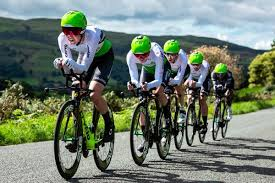

In [51]:
filename = 'test_image.jpg'
print(get_image_caption(filename,model2))
display(Image(filename))

## 2.

 A Man In A Blue Shirt Is Walking Down A Sidewalk 


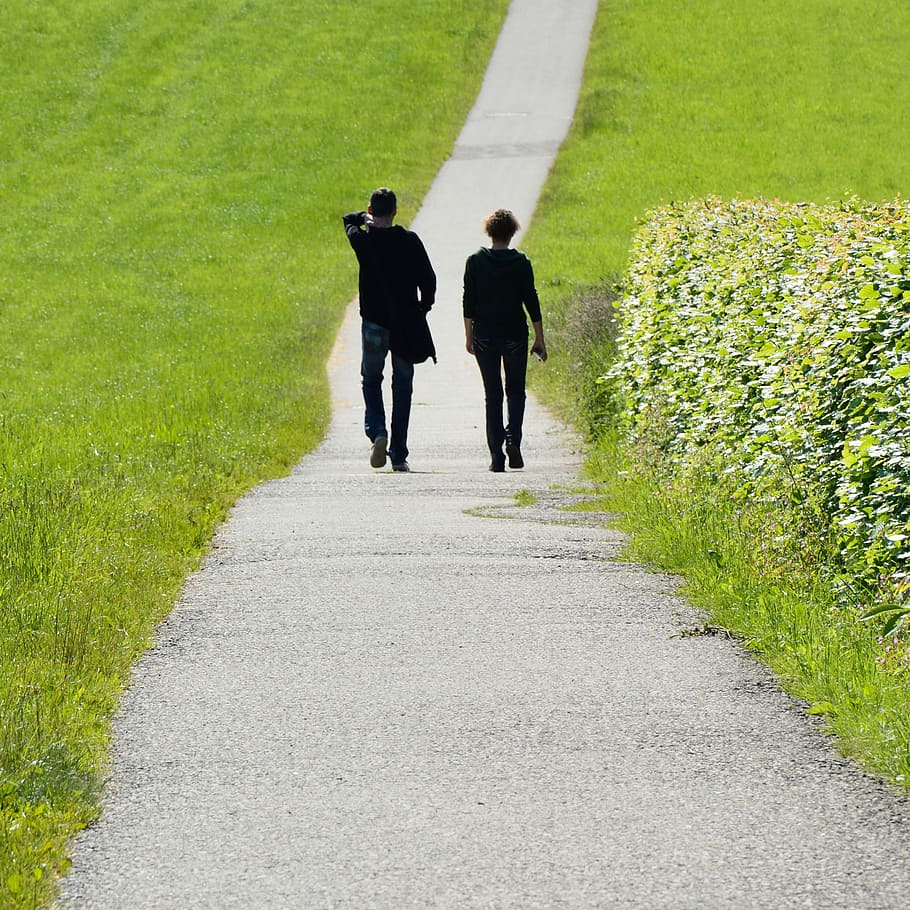

In [52]:
filename = 'test_image2.jpg'
print(get_image_caption(filename,model2))
display(Image(filename))

 A Man In A Blue Shirt Is Sitting On A Bench 


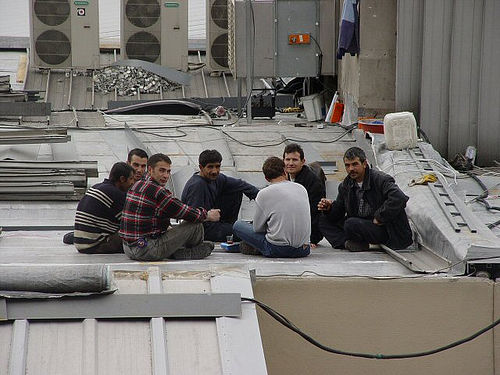

In [48]:
filename = '984950.jpg'
print(get_image_caption(filename,model2))
display(Image(filename))

 A Man In A Blue Shirt Is Sitting On A Bench 


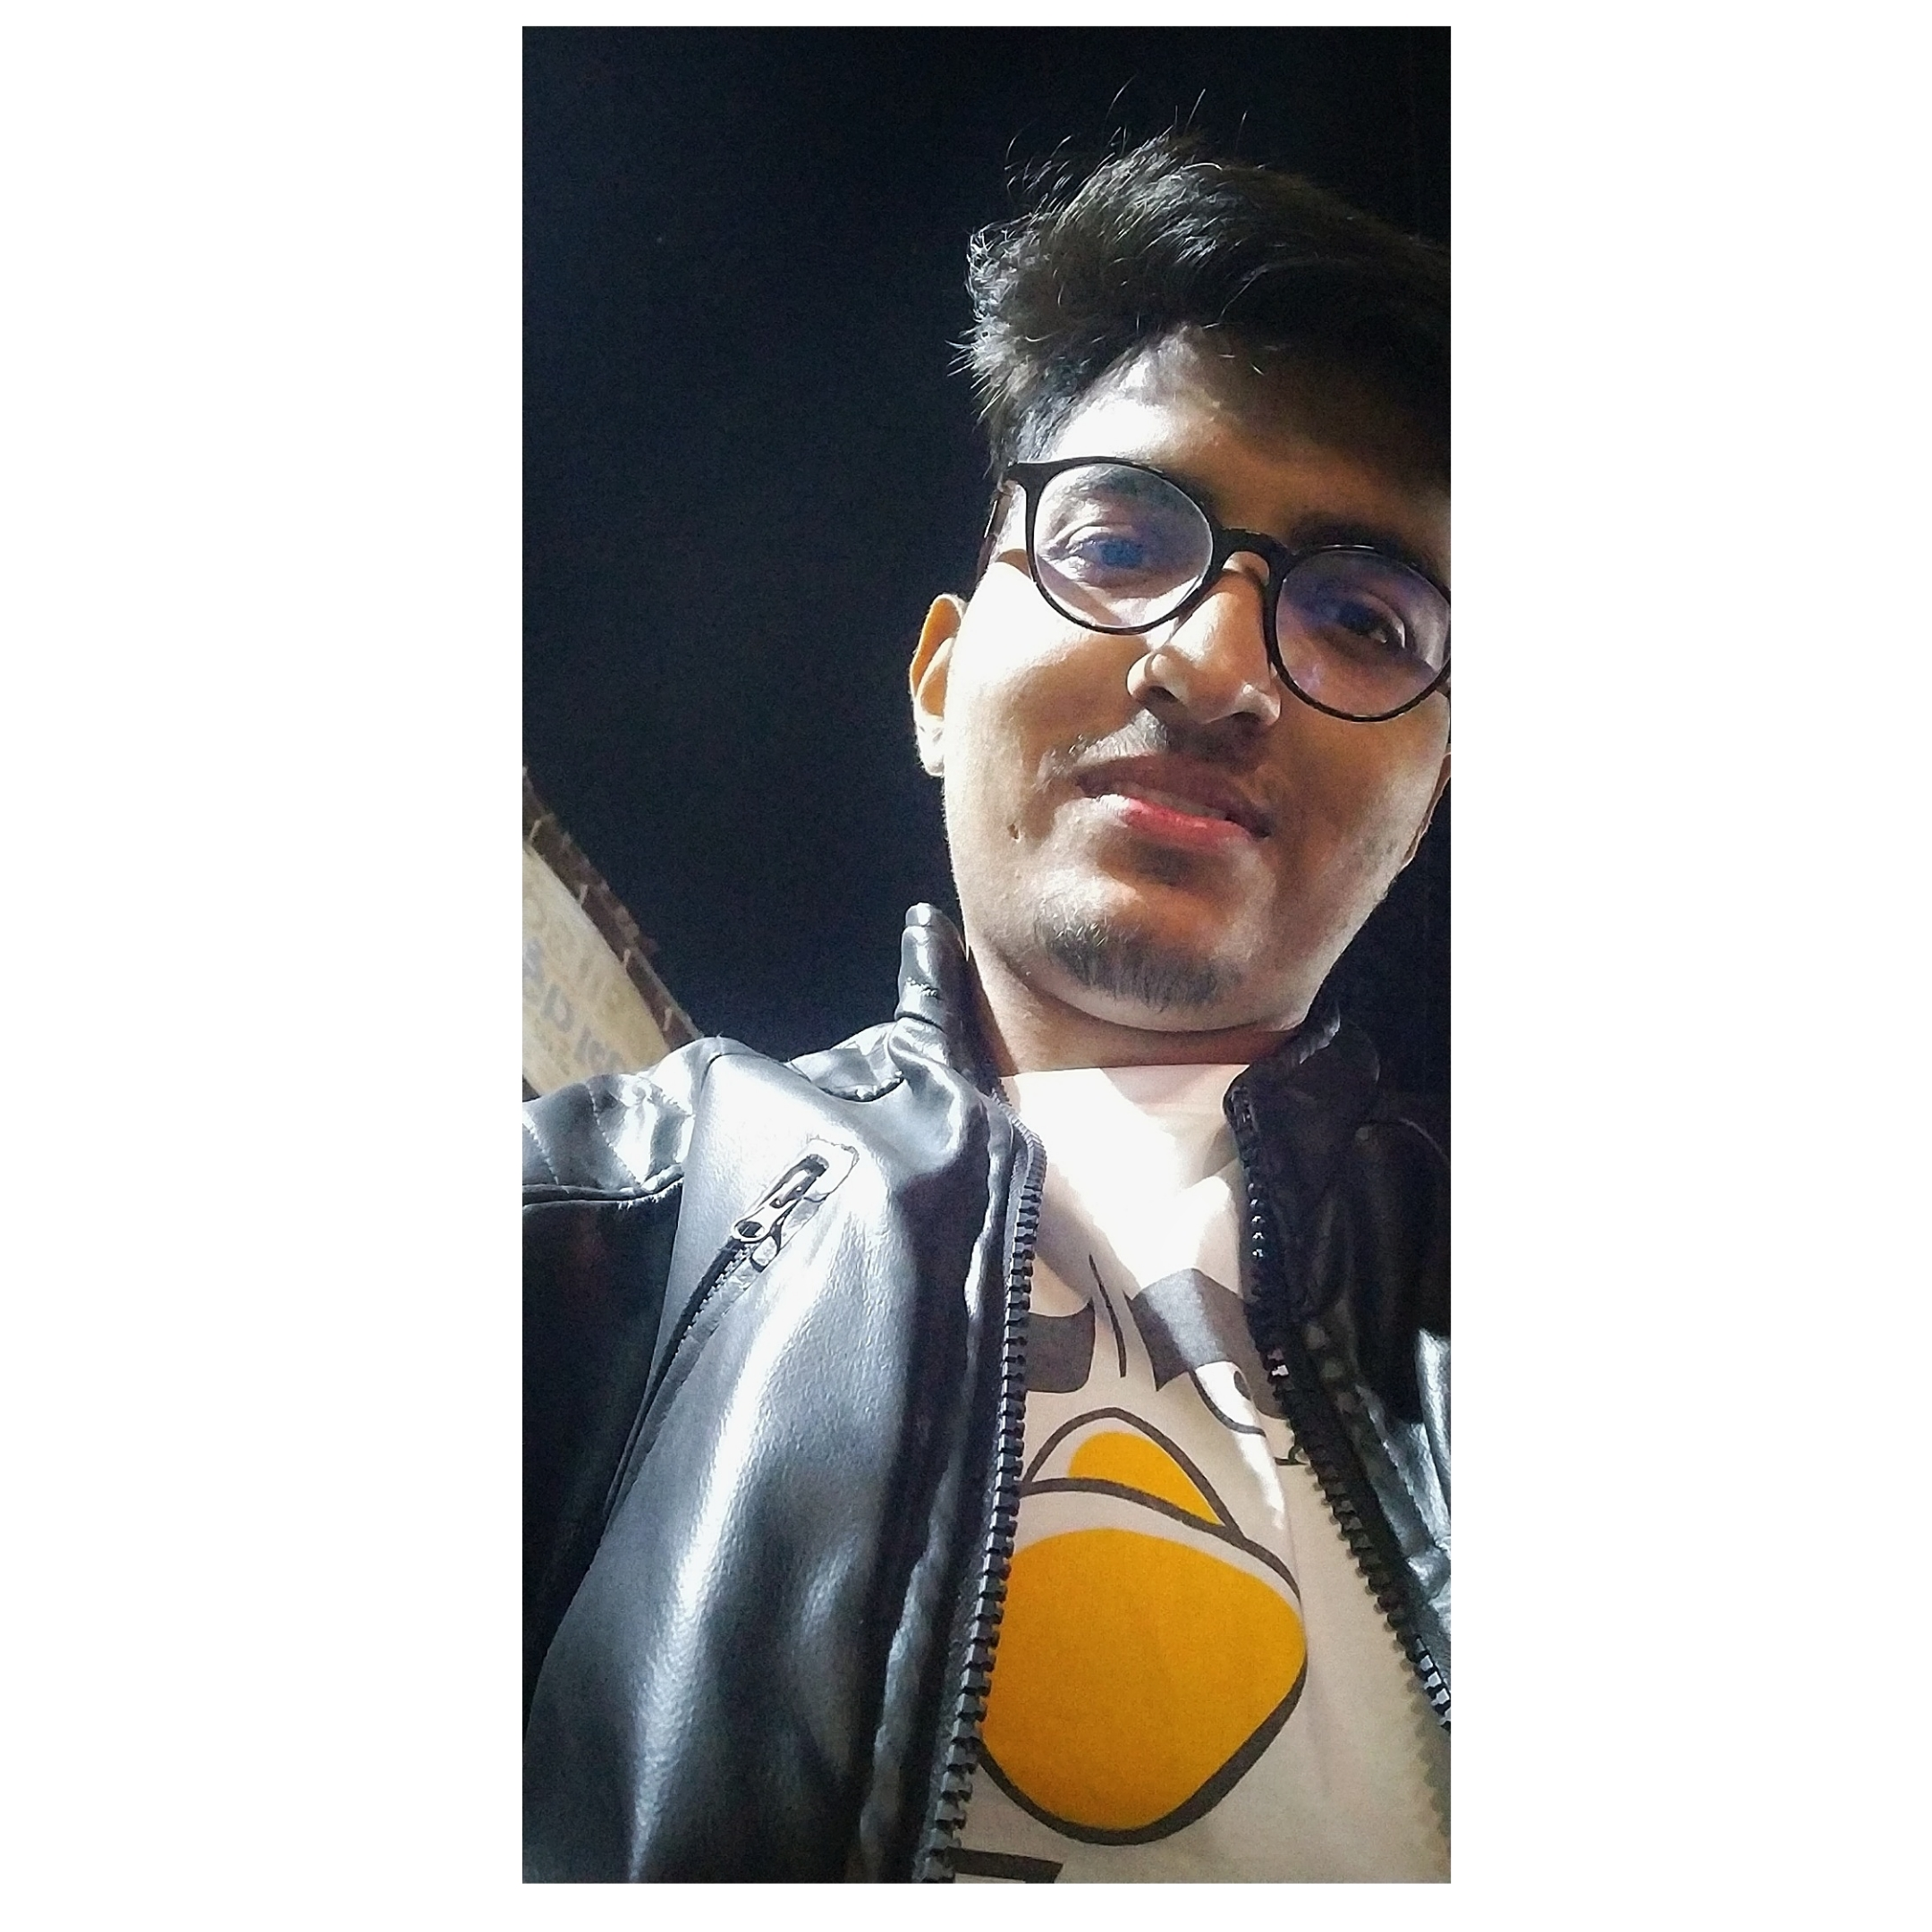

In [53]:
filename = 'MyImage.jpg'
print(get_image_caption(filename,model2))
display(Image(filename))